# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [29]:
""" P1: Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.
    Defined a function to get top n features of tf-idf vectorizer
    Ref. link: https://buhrmann.github.io/tfidf-analysis.html
"""
def top_tfidf_feats(vectorizer, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(vectorizer.idf_)
    top_feats = [(features[i], vectorizer.idf_[i]) for i in topn_ids[: top_n]]
    df = pd.DataFrame(top_feats)
    df.columns = ['Top feature', 'tfidf']
    return df

features = tf_idf_vect.get_feature_names()

n_top_features = 3000
top_features = top_tfidf_feats(tf_idf_vect, features, n_top_features)

top_features.head()

,Top feature,tfidf
0,not,1.652899
1,like,2.316965
2,good,2.378217
3,great,2.414251
4,one,2.569747


### [5.2] Calulation of Co-occurrence matrix

In [30]:
""" Generate the Co-Occurence Matrix
Ref.: 
a. https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
b. This get_coOccuranceMatrix code is copied from => https://github.com/saugatapaul1010/Amazon-Fine-Food-Reviews-Analysis/blob/master/16.%20%20Truncated%20SVD.ipynb
       
"""
def get_coOccuranceMatrix(X_train, top_features, window): #window = 2 means 2 on either side of the given word. Lets look at an example. data = [a,b,c,d,e,f,g,h],
    print("Generating the Co Occurence Matrix....")       #if window = 2, for letter c, we will have neighborhood = [a,b,c,d,e]. for f -> [d,e,f,g,h]
    dim=top_features.shape[0]
    square_matrix = np.zeros((dim,dim),int)
    
    values = [i for i in range(0,top_features.shape[0])]  #Contains all the top TF-IDF Scores as values.
    keys = [str(i) for i in top_features['Top feature']]    #Contains all the corresponding features names as keys.
    lookup_dict = dict(zip(keys,values))                  #We will use this dictionary as a look up table 

    top_words= keys
    
    #Processing each reviews to build the co-occurence Matrix
    for reviews in tqdm(X_train):
        #Split each review into words
        words = reviews.split()
        lnt = len(words)
        for i in range(0,len(words),1):
            idx_of_neigbors= []
            if((i-window >= 0) and (i+window < lnt)):
                idx_of_neigbors = np.arange(i-window,i+window+1)
            elif((i-window < 0) and (i+window < lnt)): 
                idx_of_neigbors = np.arange(0, i+window+1)
            elif((i-window >= 0) and (i+window >= lnt)):
                idx_of_neigbors = np.arange(i-window, lnt)
            else:
                pass
            #nei = [words[x] for x in idx_of_neigbors]
            #print(words[i],"---------",nei)
            #print(idx_of_neigbors)
            
            for j in idx_of_neigbors:
                if((words[j] in top_words) and (words[i] in top_words)):
                    row_idx = lookup_dict[words[i]]     #Get the index of the ith word from the lookup table
                    col_idx = lookup_dict[words[j]]     #Get the index of the jth word from the lookup table
                    square_matrix[row_idx,col_idx] += 1 #If word[i] and word[j] occurs in a neighbourhood of 5, there co occurence will be increases by one.
                else:
                    pass
                    
    #Fill all the diagonal elements of the co-occurence matrix with 0, as co-occurence of a word with itlself is always zero.                
    np.fill_diagonal(square_matrix, 0) 
    print("Co Occurence Matrix is generated....")      
    
    #Create a co-occurence dataframe.
    co_occur_df=pd.DataFrame(data=square_matrix, index=keys, columns=keys)
    return co_occur_df


co_occur_matrix = get_coOccuranceMatrix(X_data, top_features, window=2)

  0%|          | 18/100000 [00:00<11:37, 143.32it/s]

Generating the Co Occurence Matrix....


100%|██████████| 100000/100000 [12:27<00:00, 133.84it/s]

Co Occurence Matrix is generated....


### [5.3] Finding optimal value for number of components (n) to be retained.

In [31]:
from sklearn.decomposition import TruncatedSVD

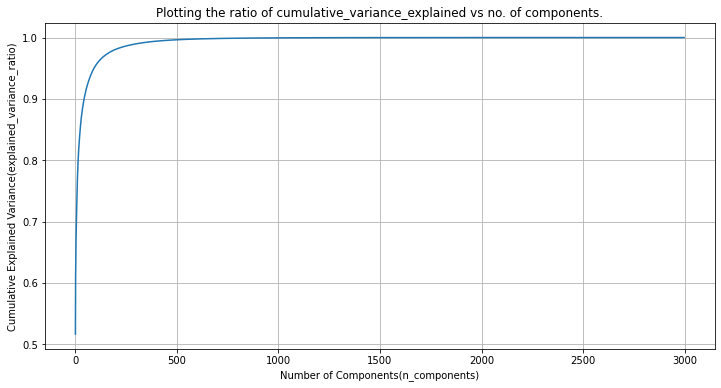

In [37]:
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
n_components = co_occur_matrix.shape[0]- 1

model = TruncatedSVD(n_components = n_components)
model.fit(co_occur_matrix)

cumulative_variance_explained = np.cumsum(model.explained_variance_ratio_)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_variance_explained)
plt.grid()
plt.title('Plotting the ratio of cumulative_variance_explained vs no. of components.')
plt.xlabel('Number of Components(n_components)')
plt.ylabel('Cumulative Explained Variance(explained_variance_ratio)')
plt.show()

### [5.4] Applying k-means clustering

#### Created functions to breakdown the clustering relevant tasks

In [33]:
from sklearn.cluster import KMeans
import math
from sklearn.preprocessing import StandardScaler

In [38]:
def hyper_tuning(X_data):
  n_inertia = []
  clusters = list(range(2, 15, 2))

  for i in clusters:
    kmeans = KMeans(n_clusters=i, n_jobs= -1)
    kmeans.fit(X_data)
    n_inertia.append(kmeans.inertia_)

  n = [math.log(i, 10) for i in n_inertia]
  plt.plot(clusters, n)
  # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
  plt.xlabel("Hyper-param(n_cluster)")
  plt.ylabel("Loss(inertia)")
  plt.title("ERROR PLOT")
  plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [120]:
"""Ref. links:
https://www.geeksforgeeks.org/generating-word-cloud-python/,
https://github.com/saugatapaul1010/Amazon-Fine-Food-Reviews-Analysis/blob/master/13.%20KMeans%2B%2B%20Clustering.ipynb 
Some of the code is modified acc. to the need.
"""

def word_clouds_kmeans(kmeans_object, optimal_k, X_corpus):
  '''This method is used to draw word clouds for the words available in all the reviews in different clusters.'''
  
  stopwords = {word for word in STOPWORDS if word not in {'not'}} #https://stackoverflow.com/questions/59293686/my-word-cloud-is-missing-three-out-of-the-four-words-in-my-string-how-do-i-add
  #Labels of each data point
  labels=kmeans_object.labels_
  clusters_dict = {i: np.where(labels == i)[0] for i in range(optimal_k)}
  # Transform this dictionary into list (if you need a list as result)
  clusters_list = []
  print("The number of datapoints in each cluster are as follows : ")
  for key, value in clusters_dict.items():
      temp = [key,value]
      clusters_list.append(temp)
      print("Cluster = {}, Number of reviews = {}".format(key,len(value)))

  for cluster_number in range(optimal_k):
      cluster = [clusters_dict[cluster_number][i] for i in range(clusters_dict[cluster_number].size)]

      reviews_cluster = []
      for i in cluster: 
        if (X_corpus[i]!= ''):
          reviews_cluster.append(X_corpus[i])

      review_corpus = ""   
      for review in reviews_cluster:
        if(review != ''):
          review_corpus = review_corpus + " " + review

      # lower max_font_size
      wordcloud = WordCloud( max_words=50, 
                            min_font_size=4, random_state=42, stopwords = stopwords, contour_color='black', repeat=False).generate(str(review_corpus))
      plt.figure(figsize=(16,9))
      plt.title("Word Cloud for Cluster {}".format(cluster_number))
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()

#### Applying clustering technique:
1. hyper-tuning(elbow plot)
2. Word cloud representation

In [36]:
#Decompose/ factorizing the co-occurence matrix into U, Sigma and V-Transpose
model = TruncatedSVD(n_components= 500)
U = model.fit_transform(co_occur_matrix) # Fit LSI model to X and perform dimensionality reduction on X
V_Transpose = model.components_
print("Shape of U: ", U.shape)

Shape of U:  (3000, 500)


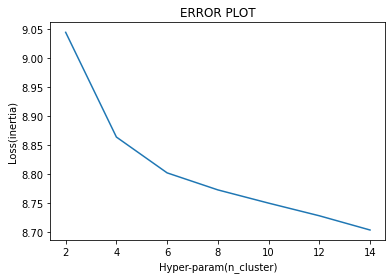

In [39]:
hyper_tuning(U)

### [5.5] Wordclouds of clusters obtained in the above section

The number of datapoints in each cluster are as follows : 
Cluster = 0, Number of reviews = 276
Cluster = 1, Number of reviews = 2648
Cluster = 2, Number of reviews = 1
Cluster = 3, Number of reviews = 15
Cluster = 4, Number of reviews = 3
Cluster = 5, Number of reviews = 57


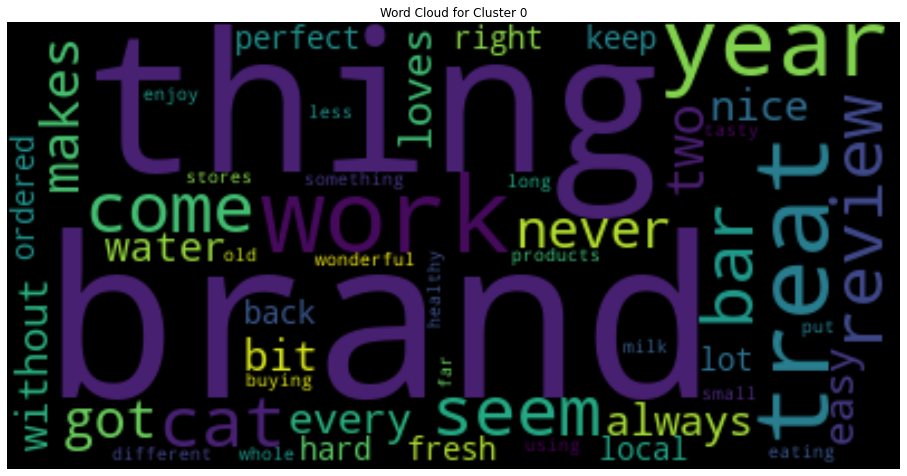

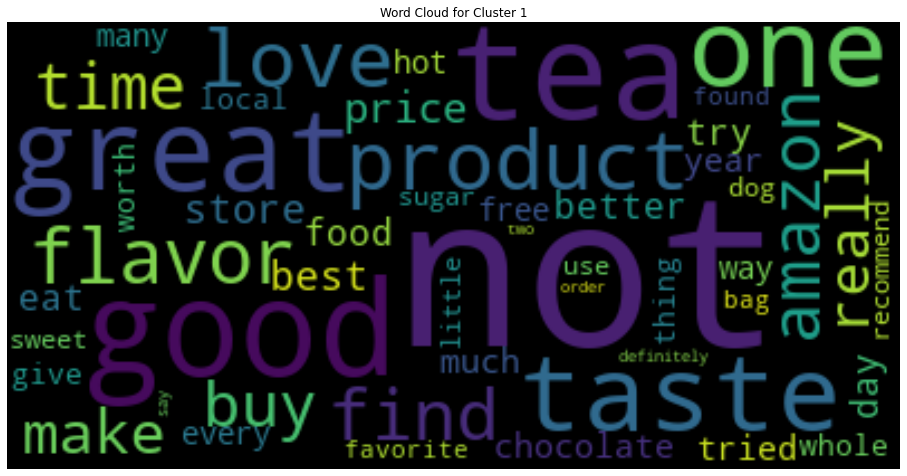

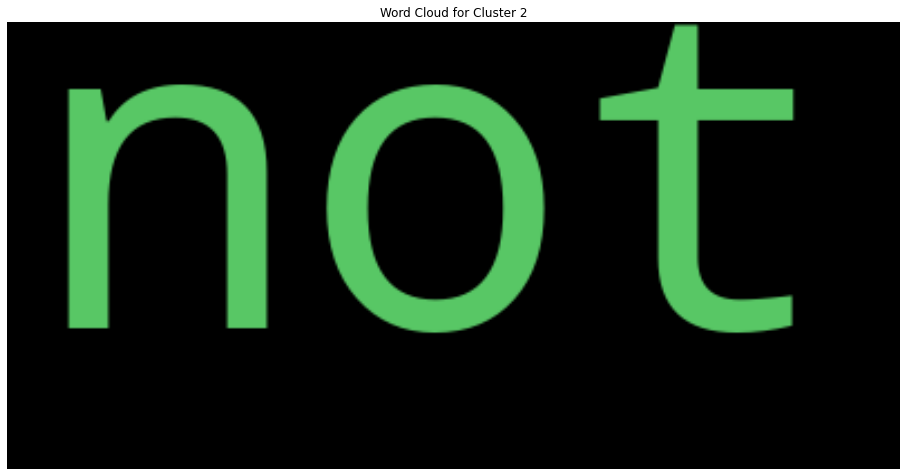

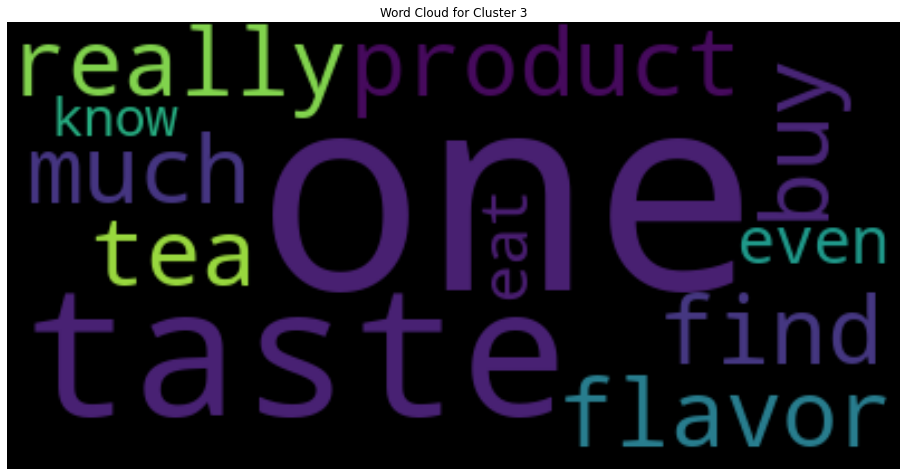

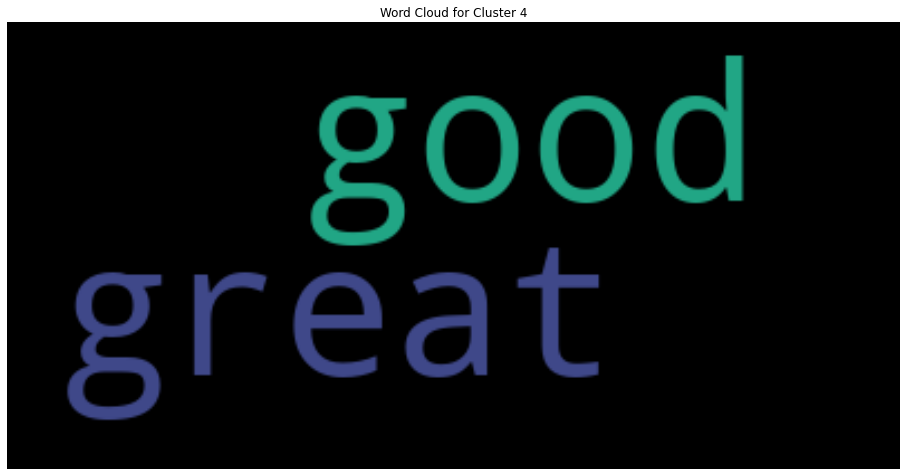

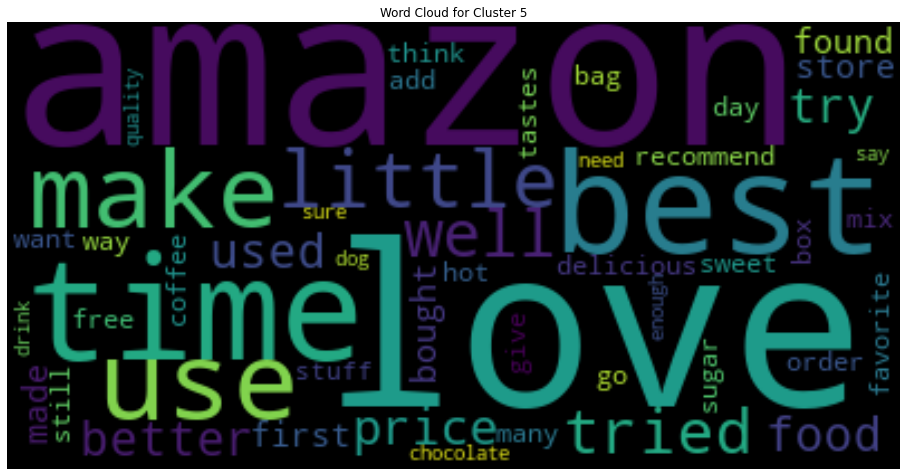

In [123]:
model = KMeans(n_clusters=6, n_jobs= -1)
model.fit(U)
word_clouds_kmeans(kmeans_object= model, optimal_k= 6, X_corpus= top_features['Top feature'])

### [5.6] Function that returns most similar words for a given word.

In [125]:
from numpy import dot
from numpy.linalg import norm
from prettytable import PrettyTable


In [126]:
# Ref. link: https://github.com/saugatapaul1010/Amazon-Fine-Food-Reviews-Analysis/blob/master/16.%20%20Truncated%20SVD.ipynb
# Some of the code is modified 

#Function to obtain Cosine distances between any two vectors.
def cosine_sim(data_point1, data_point2):
    cos_dis = dot(data_point1, data_point2)/(norm(data_point1)*norm(data_point2))
    return (1-cos_dis) #cosine distance = 1 - cosine similarity

#Function to obtain the 10 nearest words(semantically by meaning) for any input word, i.e. 
#a function that takes a word and returns the most similar words using cosine similarity between the vectors.
def get_nearest_words(U,top_features,input_word):
    print("Words related to '{}':".format(input_word))

    top_words=list(top_features['Top feature'])
    if input_word in top_words:
        for i in range(len(top_words)):
            if input_word == top_words[i]:
                index = i
                
        similarity_values = []
        for i in range(U.shape[0]): #U contains word vectors corresponding to all words.
            similarity_values.append(cosine_sim(U[i], U[index]))
            
        sorted_indexes = np.array(similarity_values).argsort()
        
        #Display top 10 nearest words to the input words in a PrettyTable format.
        sim_words = []
        sim_scores = []
        for i in range(1, 11):
            sim_words.append(top_words[sorted_indexes[i]])
            sim_scores.append(1-similarity_values[sorted_indexes[i]])
        
        table = PrettyTable()
        table.add_column("Similar Words", sim_words)
        table.add_column("Similarity Scores", sim_scores)
        print(table)

    else:
        print("This word is not present in the vocabulary of top words.")
        
    print('\n')
        
#Get 10 nearest words for any given words.
get_nearest_words(U,top_features,"amazon")
get_nearest_words(U,top_features,"coffee")
get_nearest_words(U,top_features,"meat")
get_nearest_words(U,top_features,"cat")
get_nearest_words(U,top_features,"product")
get_nearest_words(U,top_features,"vanilla")
get_nearest_words(U,top_features,"bacon")
get_nearest_words(U,top_features,"like")

Words related to 'amazon':
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|     online    | 0.7870172904852869 |
|    internet   | 0.7475366262193258 |
|      item     | 0.7249122117501213 |
|      sale     | 0.7208369723162031 |
|    walmart    | 0.6919011813558812 |
|     costco    | 0.6909977915349189 |
|     vendor    | 0.6907596011876324 |
|    bargain    | 0.6902701976743016 |
|     target    | 0.6888691709638222 |
|  considering  | 0.6844372493526905 |
+---------------+--------------------+


Words related to 'coffee':
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|      also     | 0.8164632448369135 |
|     still     | 0.7973594240399519 |
|     flavor    | 0.7929742017056287 |
|    however    | 0.7925867654934001 |
|     course    | 0.7917531788369176 |
|     really    | 0.7866625693402967 |
|      kind     | 0.7846278875062985 |
|   gene

# [6] Conclusions



*    We got the optimal value of k for K means clustering as **6** using the elbow plot method so taking it as number of clusters.
*   100% data variance achieved only by **500** components.



